## Image classification with Convolutional Neural Networks

Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Dog Breed Identification

In [42]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [43]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [44]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [45]:
PATH = "data/dog-breed-identification/"

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [46]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [47]:
torch.backends.cudnn.enabled

True

## Initial exploration of data

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [48]:
label_csv = f'{PATH}labels.csv'
label_df = pd.read_csv(label_csv)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Generate a validation set

Since there is no validation set from this data set, we'll generate our own

`get_cv_idxs` will grab a random 20% from the label_csv to be used as the validation set

In [49]:
n = len(list(open(label_csv)))-1
validation_idxs = get_cv_idxs(n)
print(validation_idxs)

[2882 4514 7717 ... 8922 6774   37]


In [50]:
label_df['breed']

0                        boston_bull
1                              dingo
2                           pekinese
3                           bluetick
4                   golden_retriever
5                 bedlington_terrier
6                 bedlington_terrier
7                             borzoi
8                            basenji
9                 scottish_deerhound
10                 shetland_sheepdog
11                      walker_hound
12                       maltese_dog
13                          bluetick
14                   norfolk_terrier
15               african_hunting_dog
16           wire-haired_fox_terrier
17                           redbone
18                  lakeland_terrier
19                             boxer
20                          doberman
21                        otterhound
22                        otterhound
23                bedlington_terrier
24                             dingo
25                  golden_retriever
26                standard_schnauzer
2

In [51]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [52]:
os.listdir(PATH)

['tmp',
 'train.zip',
 'sample_submission.csv',
 'labels.csv.zip',
 'labels.csv',
 'train',
 'test.zip',
 'subm.csv',
 'test',
 'sample_submission.csv.zip']

In [53]:
files = os.listdir(f'{PATH}train')
random.shuffle(files)
print(files[0:4])

['ccbf2d7da8e85a3b60eb0ff8a87af58f.jpg', 'eaa3b3bff09bb80c64937996a1be2d92.jpg', '9adbe43816a43b4e4510c7ebdf88d1fc.jpg', '1ff37b85d9b4ad6699507eef2fae44c8.jpg']


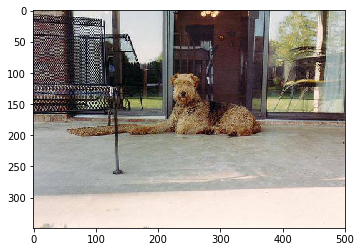

In [54]:
img = plt.imread(f'{PATH}train/{files[0]}')
#img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [55]:
img.shape

(349, 500, 3)

In [56]:
img[:4,:4]

array([[[149, 143, 127],
        [174, 168, 152],
        [181, 174, 158],
        [172, 165, 149]],

       [[166, 160, 144],
        [183, 177, 161],
        [181, 174, 158],
        [168, 161, 145]],

       [[158, 152, 138],
        [171, 165, 151],
        [164, 156, 143],
        [150, 143, 127]],

       [[137, 131, 117],
        [153, 147, 133],
        [150, 142, 129],
        [140, 132, 119]]], dtype=uint8)

## Our first model: quick start

We're using **resnext101_64** as the pre-trained model.

We'll pick

  - **transforms_side_on** since these images are dogs on their sides. (Unlike satellite images - top down view)
  - **max_zoom** = 1.1 to make the majority of the dog is still in the image
  - **bs** batch size is 58

In [58]:
sz=224
arch=resnet34
bs=58

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', val_idxs=validation_idxs,
                                    suffix='.jpg', tfms=tfms, bs=bs)
#data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
#learn = ConvLearner.pretrained(arch, data, precompute=True)
#learn.fit(0.01, 2)

IndexError: tuple index out of range

Fast AI's dataset returned from ImageClassifierData.from_csv has a convenient method `trn_ds` which returns the training dataset

In [17]:
fn = data.trn_ds.fnames
fn

array(['train/001513dfcb2ffafc82cccf4d8bbaba97.jpg', 'train/001cdf01b096e06d78e9e5112d419397.jpg',
       'train/0021f9ceb3235effd7fcde7f7538ed62.jpg', ..., 'train/ffd3f636f7f379c51ba3648a9ff8254f.jpg',
       'train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg', 'train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg'],
      dtype='<U42')

We can now check out an image to see what it looks like and watch out for a subject where it's very tiny or big in the image

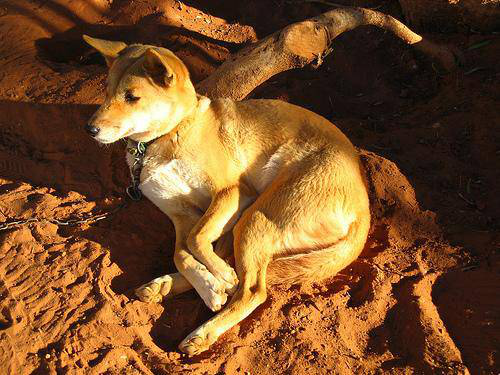

In [18]:
img = PIL.Image.open(f'{PATH}{fn[0]}'); img

In [19]:
img.size

(500, 375)

In [20]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [21]:
row_sz,col_sz = list(zip(*size_d.values()))

In [22]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [23]:
row_sz[:5]

array([500, 500, 500, 500, 500])

Here we are looking at the distribution of the dimension of the images

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

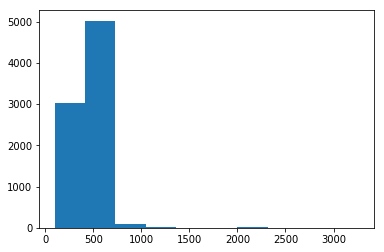

In [24]:
plt.hist(row_sz)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

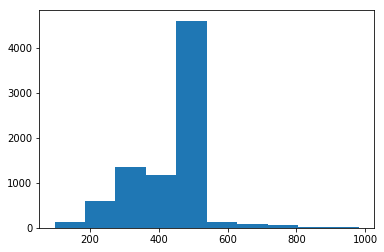

In [25]:
plt.hist(row_sz[row_sz<1000])

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

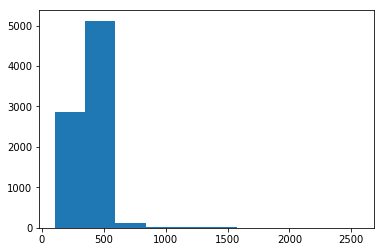

In [26]:
plt.hist(col_sz)

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

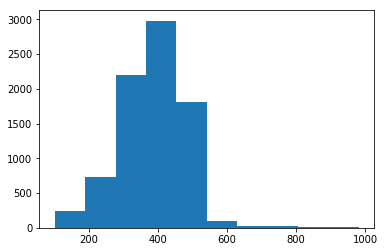

In [27]:
plt.hist(col_sz[col_sz<1000])

### Size of the training set, test set and validation set

In [28]:
len(data.trn_ds), len(data.test_ds), len(data.val_ds)

(8178, 10357, 2044)

In [29]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Review: easy steps to train a world-class image classifier

## Initial Model

The reasoning for the line below is because of efficiency
```python
    return data if sz>300 else data.resize(340, 'tmp')
```
According to Jeremy in this [link](http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13?u=johnny), 
> The transforms downsize the images to 224 or 299. Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time.

In [30]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4, val_idxs=validation_idxs, suffix='.jpg', tfms=tfms, bs=bs)

    return data if sz>300 else data.resize(340, 'tmp')


### Precompute

In [31]:
data = get_data(sz,bs)

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [33]:
lrf=learn.lr_find()

 87%|████████▋ | 123/141 [00:03<00:00, 32.66it/s, loss=14.1]


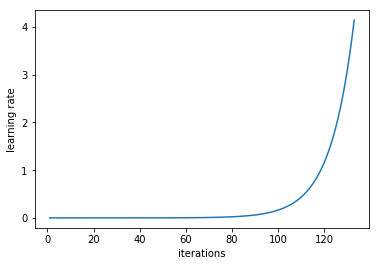

In [34]:
learn.sched.plot_lr()

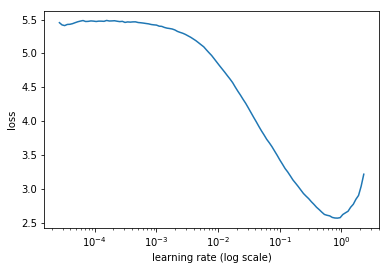

In [35]:
learn.sched.plot()

In [36]:
learn.fit(1e-1, 5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.701877   0.382645   0.876712  
    1      0.381168   0.371668   0.887965                    
    2      0.260912   0.332959   0.90411                     
    3      0.182959   0.340377   0.906556                    
    4      0.17242    0.346458   0.904599                    



[array([0.34646]), 0.9045988262399536]

### Dropout

In [37]:
data = get_data(sz, bs)

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

NameError: name 'arch' is not defined

In [39]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.134999   0.430614   0.900685  
    1      0.524152   0.307827   0.919276                    



[array([0.30783]), 0.9192759378315651]

### Precompute False

In [40]:
learn.precompute=False

In [41]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.453434   0.288828   0.91683   
    1      0.415853   0.268382   0.921722                    
    2      0.377932   0.263151   0.921233                    
    3      0.351505   0.258973   0.925147                    
    4      0.340152   0.25173    0.921722                    



[array([0.25173]), 0.9217221171771943]

In [42]:
learn.save('224_pre')

In [43]:
learn.load('224_pre')

### Increase size of data (images)

The step below is a lesser known optimization according to Jeremy [video](https://youtu.be/JNxcznsrRb8?t=1h32m57s)
By increasing the image size from 224 to 299, he got state-of-the-art results.

**The trick is to start training on smaller images and then switch to larger images. According to him, it avoid overfitting.**

In [44]:
learn.set_data(get_data(299,bs))
learn.freeze()

In [45]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.321334   0.230901   0.930039  
    1      0.30811    0.225711   0.930528                    
    2      0.287119   0.22115    0.929061                    



[array([0.22115]), 0.9290606653620352]

In [25]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.324816   0.227577   0.928082  
    1      0.31412    0.22313    0.931018                    
    2      0.276775   0.219219   0.931996                    
    3      0.267837   0.217204   0.931018                    
    4      0.252199   0.213484   0.927104                    
    5      0.229628   0.206525   0.934932                    
    6      0.230333   0.206829   0.93591                     


[array([0.20683]), 0.9359099874874384]

In [48]:
log_preds, y = learn.TTA()

In [58]:
probs = np.mean(np.exp(log_preds), 0)

In [59]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9373776908023483, 0.22078864786174834)

In [60]:
learn.save('299_pre')

In [9]:
learn.load('299_pre')

NameError: name 'learn' is not defined

Just try it one more time to see if we can squeeze more out of the model

In [62]:
learn.fit(1e-2, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.283746   0.222554   0.930528  
    1      0.250192   0.218647   0.928082                    



[array([0.21865]), 0.9280821946385789]

In [63]:
learn.save('299_pre')

In [64]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9344422700587084, 0.21794620105978918)

In [65]:
log_preds, y = learn.TTA()

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [83]:
# This is the label for a val data
data.val_y

array([ 19,  15,   7, ..., 109,   3,  28])

In [84]:
# from here we know that 'affenpinscher' is label 0 and 'afghan_hound' is label 1 and so on...
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [68]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2044, 120)

In [85]:
log_preds[:1]

array([[-12.89025, -13.75703, -12.7269 , -13.25721, -12.34379, -12.41874, -12.48588, -10.00273, -12.45126,
        -13.25246, -11.12476, -12.24652, -14.68935, -11.24485, -13.19497, -13.57378, -12.14106, -13.65662,
        -12.84351,  -0.00322, -12.21817,  -8.84211, -10.23955, -13.05434, -12.77672, -11.38828, -13.88353,
         -8.96524, -14.54652,  -9.43741, -12.31464, -11.69602, -11.36621, -11.59125, -12.94814, -12.55227,
        -11.30166, -12.82821, -13.33298, -13.1655 , -14.03839,  -9.77651, -13.96815, -12.90176, -14.30851,
         -6.28137, -13.62124, -13.18187, -14.00568, -13.05611, -14.09112, -13.87446, -13.65874, -11.6861 ,
        -13.06745, -13.11644, -13.51529, -12.09283, -12.73686, -13.94917,  -9.81321, -10.25777, -13.41155,
        -11.64172, -14.10747, -13.67009, -15.9185 , -13.77881, -12.77406, -13.90991, -12.7699 , -13.23879,
        -12.82335, -12.86534, -10.98792, -12.09869, -12.31869, -10.12133, -12.54489, -13.34234, -13.54013,
        -14.00776, -11.73965, -12.878

In [70]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [112]:
class_preds = [data.classes[index_pred] for index_pred in preds]
fnames_nopath = [fname[5:] for fname in data.test_ds.fnames]
fname_preds = list(zip(fnames_nopath, class_preds))
df = pd.DataFrame(fname_preds)
df.columns = ["id", "species"]
df.to_csv(f'{PATH}subm.csv', index=False)
df

,id,species
0,fd1a7be32f10493735555e62913c0841.jpg,boston_bull
1,5273d42f02b4715cb93845205995ef64.jpg,bluetick
2,442057a3142f4d75a1023db363e2fb54.jpg,basenji
3,fb03302b030afd122e0f4936c158f6c1.jpg,shetland_sheepdog
4,511ca6e3539192aa5c8747bb697e0525.jpg,maltese_dog
5,2e60533a26e589f57fff34711c5ba73c.jpg,norwich_terrier
6,27e4bd954bfe78f9e01338dc5108fadd.jpg,boxer
7,591566259cbc95dd43b75d77b00aa7a5.jpg,doberman
8,a51c2803972dff8c7fcc17f6b7eda64d.jpg,bedlington_terrier
9,9ace4c5cced4fb88678a5b0a9b3f3cf1.jpg,cairn


In [71]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [95]:
rand_by_correct(True)

array([ 357,  700, 1085,    4])

In [72]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [73]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [74]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


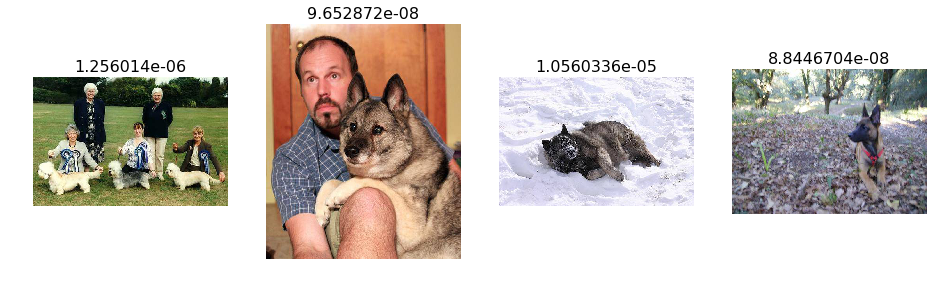

In [75]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


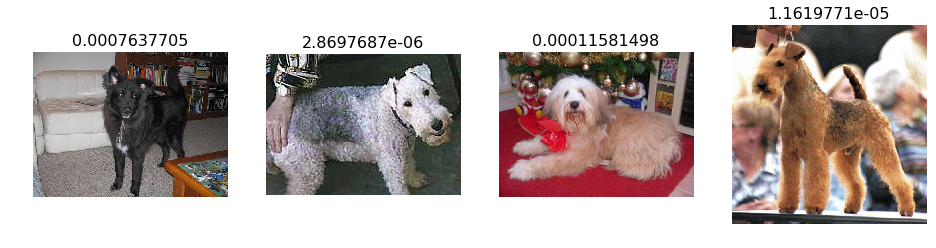

In [96]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [97]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


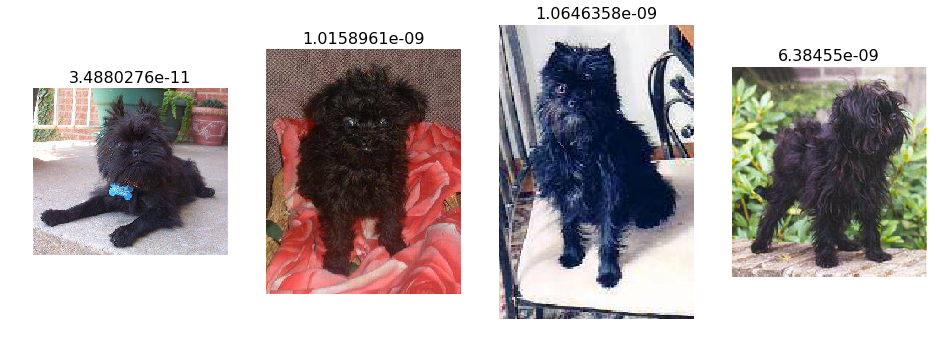

In [98]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


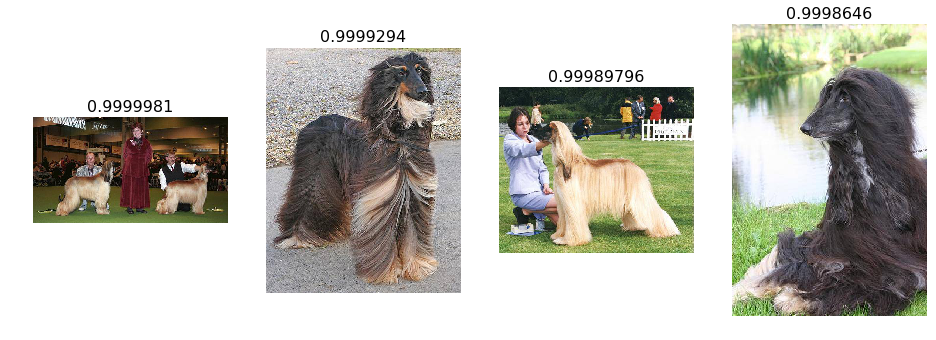

In [99]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [100]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect cats


<Figure size 1152x576 with 0 Axes>

In [101]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most incorrect dogs


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


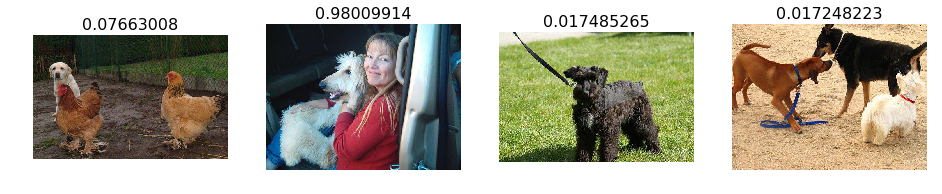

In [102]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")